# Import necessary packages

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # boxplot, histplot
import cv2

# The latest keras-preprocessing
!pip install git+https://github.com/keras-team/keras-preprocessing.git

from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
import tensorflow as tf
#from keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Rescaling, Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix


  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-kknuy1us
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-kknuy1us
  Resolved https://github.com/keras-team/keras-preprocessing.git to commit 3e380065d4afc7347aaee8d89325a16b22158438
  Preparing metadata (setup.py) ... done


# Loading Data from Google Drive
Images in the original dataset have been converted into 256*256 .png format

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
#!ls "/content/gdrive/My Drive"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
df_train = pd.read_csv('/content/gdrive/My Drive/train.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/test.csv')
#df_train.info()
#df_test.info()
df_train['cancer'].unique()
df_train['cancer'].value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

# Data Preprocessing
## Balance the data

In [5]:
df_benign = df_train[df_train['cancer'] == 0]
df_malign = df_train[df_train['cancer'] == 1]

df_benign = df_benign.sample(n=1202, random_state=1) # Make sure each time random the same samples.

df_benign = df_benign.reset_index()
df_malign = df_malign.reset_index()

# interleave these two dataframes
df_sample = pd.concat([df_benign,df_malign]).sort_index().set_index('index')

#print(df_sample['cancer'].to_string(index=False))

Observation: Now we have a almost perfect balanced sample dataset!

In [6]:
# Create image_name matching the name in the image name directory by concatenating the patient_id and image_id
df_sample['image_name'] = df_sample["patient_id"].astype(str) + '_' + df_sample["image_id"].astype(str)
df_test['image_name'] = df_test["patient_id"].astype(str) + '_' + df_test["image_id"].astype(str)

In [7]:
# The append_ext function is defined to append extension to the image name
# Note
def append_ext(fname):
  if fname.endswith('.png'):
    print('Silly code: Do not add suffix twice.')
  else: return fname+'.png'

df_sample['image_name']=df_sample['image_name'].apply(append_ext)
print(df_sample.head())

df_test['image_name']=df_test['image_name'].apply(append_ext)
print(df_test.head())

       site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
index                                                                          
38182        2       50994   799654229          R   CC  55.0       0       0   
87           1       10130   388811999          L  MLO  71.0       1       1   
11895        2       22706  1838448164          L   CC  63.0       0       0   
88           1       10130   613462606          L   CC  71.0       1       1   
38810        2       51875  1763503482          R   CC  57.0       0       0   

       invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
index                                                                           
38182         0     NaN        0     NaN          21                    False   
87            1     0.0        0       B          49                    False   
11895         0     NaN        0     NaN          21                    False   
88            1     0.0        0  

# Split the sample dataset into training set and validation set:
   

*   training set contains 80% records, and validation set has the rest 20% instances.
*   Keras ImageDataGenerator to map the images in the RSNA_256 directory to the class cancer in the corresponing df_sample.
*   The batch_size of the training set and the validation set has set as the number that divides the total number of images in the train set and valid respectively.






In [8]:
# Source Code: https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
# Modified by Jia Lin
datagen=ImageDataGenerator(validation_split =0.2)
train_generator=datagen.flow_from_dataframe(dataframe=df_sample,
                                            directory="/content/gdrive/My Drive/RSNA_256/",
                                            x_col="image_name",
                                            y_col="cancer",
                                            subset="training",
                                            batch_size=32, # 1888 = 8*4*59
                                            seed=0,
                                            shuffle=True,
                                            color_mode="grayscale", # the original dataset only gray
                                            class_mode="raw", # 'cancer' is numerical datatype
                                            target_size=(256,256))


Found 1888 validated image filenames.


In [9]:
valid_generator=datagen.flow_from_dataframe(dataframe=df_sample,
                                            directory="/content/gdrive/My Drive/RSNA_256/",
                                            x_col="image_name",
                                            y_col="cancer",
                                            subset="validation",
                                            batch_size=8, # 472 = 8*59
                                            seed=0,
                                            shuffle=True,
                                            color_mode="grayscale",
                                            class_mode="raw", # 'cancer' is numerical datatype
                                            target_size=(256,256))


Found 472 validated image filenames.


In [10]:
from collections import Counter
count = Counter(train_generator.labels)[1]
print(count)
#print(train_generator.labels)
#print(valid_generator.labels)

922


In [11]:
test_datagen=ImageDataGenerator()
test_generator=test_datagen.flow_from_dataframe(dataframe=df_test,
                                                directory="/content/gdrive/My Drive/testing_images/",
                                                x_col="image_name",
                                                y_col=None,
                                                batch_size=1,
                                                seed=0,
                                                shuffle=False,
                                                color_mode="grayscale",
                                                class_mode=None,
                                                target_size=(256,256))

Found 4 validated image filenames.


# Build the model:

In [12]:
# Define the CNN model
model = Sequential()

model.add(Rescaling(1./255, offset=0.0, input_shape=(256,256,1)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(2, activation='softmax')) # Two classes output

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 254, 254, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                        

In [14]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [15]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
print(STEP_SIZE_TRAIN)
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_VALID)
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
print(STEP_SIZE_TEST)

59
59
4


# Fitting/Training the model

In [16]:
model.fit(train_generator,  validation_data=valid_generator, epochs=32)

Epoch 1/32
59/59 [==============================] - 1079s 18s/step - loss: 1.1345 - accuracy: 0.5090 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/32
59/59 [==============================] - 8s 136ms/step - loss: 0.6918 - accuracy: 0.5191 - val_loss: 0.6862 - val_accuracy: 0.5932
Epoch 3/32
59/59 [==============================] - 8s 130ms/step - loss: 0.6844 - accuracy: 0.5662 - val_loss: 0.6898 - val_accuracy: 0.5614
Epoch 4/32
59/59 [==============================] - 8s 129ms/step - loss: 0.6526 - accuracy: 0.5953 - val_loss: 0.7554 - val_accuracy: 0.5297
Epoch 5/32
59/59 [==============================] - 8s 136ms/step - loss: 0.5711 - accuracy: 0.6811 - val_loss: 0.8081 - val_accuracy: 0.5064
Epoch 6/32
59/59 [==============================] - 8s 129ms/step - loss: 0.3901 - accuracy: 0.8136 - val_loss: 1.1611 - val_accuracy: 0.5064
Epoch 7/32
59/59 [==============================] - 8s 138ms/step - loss: 0.2217 - accuracy: 0.8925 - val_loss: 1.8122 - val_accuracy: 0.5000
Epoch

# Evaluate the model


In [17]:
model.evaluate(valid_generator, steps = STEP_SIZE_VALID)

59/59 [==============================] - 2s 25ms/step - loss: 8.2589 - accuracy: 0.4682


[8.258935928344727, 0.4682203531265259]

59/59 [==============================] - 1s 20ms/step
Confusion Matrix:
[[120 116]
 [141  95]]


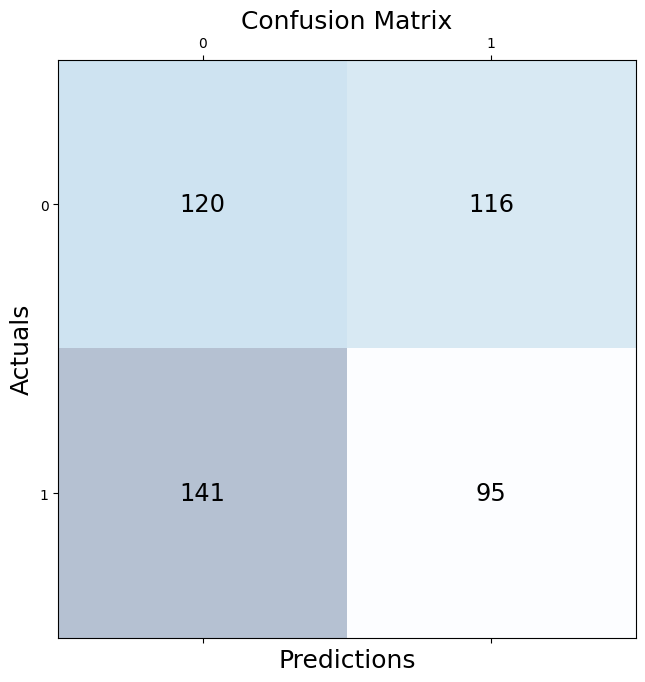

              precision    recall  f1-score   support

      Benign       0.46      0.51      0.48       236
      Malign       0.45      0.40      0.43       236

    accuracy                           0.46       472
   macro avg       0.46      0.46      0.45       472
weighted avg       0.46      0.46      0.45       472



In [18]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
pred = model.predict(valid_generator)
pred = np.argmax(pred, axis=1)
print('Confusion Matrix:')
confusion_matrix = confusion_matrix(valid_generator.labels, pred)
print(confusion_matrix)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

target_names = ['Benign','Malign']
print(classification_report(valid_generator.labels, pred, target_names=target_names, zero_division=0))

# Predict the output

In [20]:
filenames = test_generator.filenames
number_test_samples = len(filenames)
test_generator.reset()
pred = model.predict(test_generator, number_test_samples)
pred = np.argmax(pred, axis = 1)
print(pred)

4/4 [==============================] - 0s 11ms/step
[0 0 0 0]
